# CX 4230, Project 2A


## Setup

Run these code cells to get started.

In [1]:
# Our usual multidimensional array tools
import numpy as np
import scipy as sp
import scipy.sparse
import math
from scipy.integrate import odeint

In [2]:
 # Core plotting support
import matplotlib.pyplot as plt
from matplotlib import animation
%matplotlib inline

## Conceptual model

There are several possible conceptual models. Recall the one discussed in class:

* Model three population types as _fractions_ of the total population that vary continuously in time: $S \equiv S(t)$ for suscetible people, $I \equiv I(t)$ for infected people, and $R \equiv R(t)$ for recovered people.
* Ignore the spatial dimension and assume the subpopulations are _well-mixed_, i.e., everyone is connected to everyone else.
* Let $\tau$ be a rate of infection spread, having inverse-time units.
* Let $\rho$ be a rate of recovery, also having inverse-time units.

From these starting assumptions, we developed a conceptual model of the system as a system of _ordinary differential equations_ (ODEs):

$$
\begin{eqnarray}
  \dfrac{dI(t)}{dt} & = & \tau I(t) S(t) - \rho I(t) \\
  \dfrac{dS(t)}{dt} & = & -\tau I(t) S(t) \\
  \dfrac{dR(t)}{dt} & = & \rho I(t)
\end{eqnarray}
$$

> Recall that the $\rho I(t)$ term measures the fraction of the infected population that recovers per unit time. We also discussed a variation on this term in class, which expresses recovery using a _delay_ term, $I(t-k)$; such a term results in a [_delay differential equation_](https://en.wikipedia.org/wiki/Delay_differential_equation).

In [3]:
TAU = 0.1
RHO = 0.5

In [4]:
L_x = 1.0  # Length of x
L_y = 1.0  # Length of y
C = 0.1  # Diffusion coefficient
V = 0.7 # Vaccinate coefficient
N = 15   # Number of (spatial) grid points x-axis. The grid is M x N
M = 15   # Number of grid points y-axis
dx = float (L_x) / (N-1)       # Grid resolution
dy = float (L_y) / (M-1) 
I0 = 1.0
S0 = 1.0 - I0
R0 = 0.0
print ("=== Simulation parameters ===")
print ("  Domain of x: [0, L_x=%g]" % L_x)
print ("  Domain of y: [0, L_y=%g]" % L_y)
print ("  Diffusion coefficient: C=%g (units: [len]^2 / [time])" % C)
print ("  Grid resolution: n=%d points ==> dx=%g [len]" % (N, dx))
print ("  Grid resolution: m=%d points ==> dx=%g [len]" % (M, dy))

=== Simulation parameters ===
  Domain of x: [0, L_x=1]
  Domain of y: [0, L_y=1]
  Diffusion coefficient: C=0.1 (units: [len]^2 / [time])
  Grid resolution: n=15 points ==> dx=0.0714286 [len]
  Grid resolution: m=15 points ==> dx=0.0714286 [len]


## Simulator

To build a "simulator" for this system of ODEs, we can use a black-box ODE solver. Let's use Scipy's [`odeint()`](http://docs.scipy.org/doc/scipy-0.16.1/reference/generated/scipy.integrate.odeint.html#scipy.integrate.odeint).

Recall that a generic ODE solver expects to be given a system of the form,

$$
  \dfrac{d\vec{y}(t)}{dt} = f(t, \vec{y}),
$$

where $\vec{y}(t)$ is the vector whose $m$ components are the continuous state variables of the system,

$$
\begin{eqnarray}
  \vec{y}(t)
    & \equiv & \left(\begin{array}{c}
                 y_0(t) \\
                 y_1(t) \\
                 \vdots \\
                 y_{m-1}(t)
               \end{array}\right),
\end{eqnarray}
$$

and $\vec{f}(t, \vec{y})$ is a vector function having $m$ components that depend on the time $t$ and the state variable (components) of $\vec{y}$:

$$
\begin{eqnarray}
  \vec{f}(t, \vec{y})
    & \equiv & \left(\begin{array}{c}
                 f_0(t, \vec{y}) \\
                 f_1(t, \vec{y}) \\
                 \vdots \\
                 f_{m-1}(t, \vec{y})
               \end{array}\right).
\end{eqnarray}
$$

In [5]:
# Function to compute a centered impulse as an initial condition
def gen_initial (m,n,y0,dx,dy, impulse=None):
    u = np.zeros ((m + 2,n + 2, 3), dtype=float)
    i_mid = int (n/2)
    j_mid = int (m/2)
    for x in range(1, n + 1):
        for y in range(1, m + 1):
            u[y][x][:] = np.array([0,1,0])
    
    if impulse is None:
        u[j_mid][i_mid][:] = y0
        u[j_mid+3][i_mid-3][:] = y0
    else:
        for point in impulse:
            (x,y) = (int(point[0]/dx)+1,int(point[1]/dx)+1)
            u[x,y] = y0
    return u

In [6]:
def plot(G, vmin, vmax):
    plt.pcolor (G, vmin=vmin, vmax=vmax, edgecolor='black')
    ticks = [vmin, vmax]
    plt.colorbar (ticks=ticks)
    plt.axes().set_xlim([0,G.shape[0]])
    plt.axes().set_ylim([0,G.shape[1]])
    plt.axes().set_aspect('equal')

In [7]:
def x_axis_diffusion (G, x, y, c=C, dx=dx):
    if ( x == 1 ):
        return c*( 0 - G[y][x][0] + G[y][x+1][0])/dx**2
    elif (x == (G.shape[1] - 2) ):
        return c*( G[y][x-1][0] - G[y][x][0])/dx**2
    else:
        return c*(G[y][x-1][0] - 2*G[y][x][0] + G[y][x+1][0])/dx**2

In [8]:
def y_axis_diffusion (G, x, y, c=C, dy=dy):
    if ( y == 1 ):
        return c*( 0 - G[y][x][0] + G[y+1][x][0])/dy**2
    elif (y == (G.shape[0] - 2) ):
        return c*( G[y-1][x][0] - G[y][x][0])/dy**2
    else:
        return c*(G[y-1][x][0] - 2*G[y][x][0] + G[y+1][x][0])/dy**2

In [9]:
def f_sirode (G, t, m=M, n=N, tau=TAU, rho=RHO, c=C, dx=dx, dy=dy):
    assert type (G) is np.ndarray
    assert type (t) is float
    G = np.reshape(G, (m+2, n+2,3), order='C')
    newG = np.zeros((m+2, n+2, 3), dtype=float)
    # @YOUSE: Compute `f[:]`
    for x in range(1, G.shape[1]-1):
        for y in range(1, G.shape[0]-1): 
            f = np.zeros (np.array(G[y][x]).shape)
            x_diff = x_axis_diffusion(G, x, y, c, dx)
            y_diff = y_axis_diffusion(G, x, y, c, dy)
            cell = G[y][x]
            f[0] = tau*cell[0]*cell[1] - rho*cell[0] + (x_diff + y_diff)*cell[1]
            f[1] = -tau*cell[0]*cell[1] - (x_diff + y_diff)*cell[1]
            f[2] = rho*cell[0]
            newG[y][x][:] = f
    return newG.ravel()

In [10]:
def sim (c, m, n, tau, rho, i0, dx, dy, t_max, n_t, verbose=False, impulse=None):
    y0 = np.array ([i0, 1.0-i0, 0.0])
    G = gen_initial (m, n, y0, dx, dy, impulse)
    t_all = np.linspace (0.0, t_max, n_t)
    U = odeint (f_sirode, G.ravel(order='C'), t_all, args=(m,n, tau, rho,c,dx,dy))
    U = np.reshape(U, (n_t, m+2, n+2, 3), order='C')
    if verbose:
        print ("Time points:", t_all)
        
    return (U, t_all)

In [11]:
def show_results(U, n_t):
    minInit = np.amin(U[0,:,:,:])
    maxInit = np.amax(U[0,:,:,:])
    plt.figure(1)
    plt.title('Initial Infected')
    plot(U[0,:,:,0], minInit, maxInit)
    #print('\n\n===================Initial Infected===================')
    #print(U[0,:,:,0])
    
    plt.figure(2)
    plt.title('Initial Susceptible')
    plot(U[0,:,:,1], minInit, maxInit)
    #print('\n\n===================Initial Susceptible===================')
    #print(U[0,:,:,1])
    
    plt.figure(3) 
    plt.title('Initial Recovered')
    plot(U[0,:,:,2], minInit, maxInit)
    #print('\n\n===================Initial Recovered===================')
    #print(U[0,:,:,2])

    minFinal = np.amin(U[n_t-1,:,:,:])
    maxFinal = np.amax(U[n_t-1,:,:,:])
    
    plt.figure(4) 
    plt.title('Final Infected')
    plot(U[n_t - 1,:,:,0], minFinal, maxFinal)
    #print('\n\n===================Final Infected===================')
    #print(U[n_t - 1,:,:,0])
    
    plt.figure(5) 
    plt.title('Final Susceptible')
    plot(U[n_t - 1,:,:,1], minFinal, maxFinal)
    #print('\n\n===================Final Susceptible===================')
    #print(U[n_t - 1,:,:,1])
    
    plt.figure(6)
    plt.title('Final Recovered')
    plot(U[n_t - 1,:,:,2],minFinal, maxFinal)
    #print('\n\n===================Final Recovered===================')
    #print(U[n_t - 1,:,:,2])

<function __main__.isim>

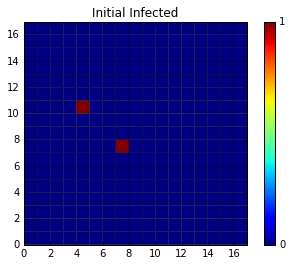

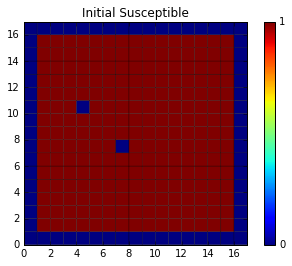

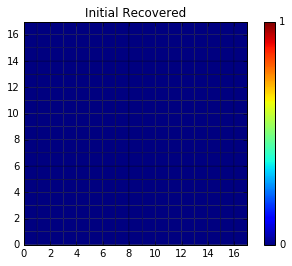

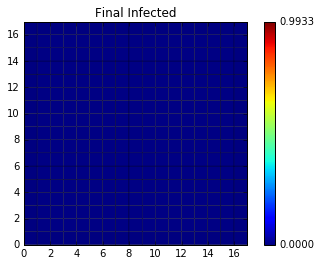

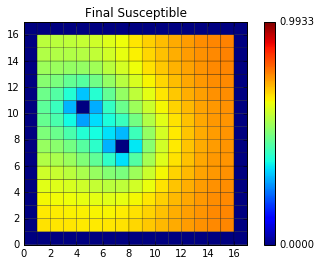

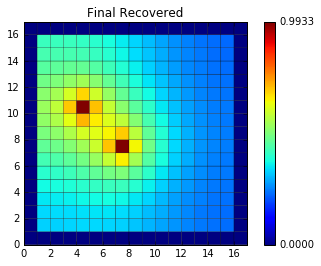

In [12]:
# Test code: Display a plotting widget that lets you adjust
# the simulation parameters and visualize the results.

from ipywidgets import interact

def isim (tau=TAU, rho=RHO, i0=1, t_max=10.0, n_t=10, c=C, m=M, n=N, lx=L_x, ly=L_y):
    assert t_max > 0.0
    dx = float (lx) / (n-1)       # Grid resolution
    dy = float (ly) / (m-1)
    (U, t_all) = sim(c, m, n, tau, rho, i0, dx, dy, t_max, n_t)
    show_results(U, n_t)
    
interact (isim
     , tau=(0.0, 2, 0.1)
     , rho=(0.0, 2.0, 0.1)
     , i0=(0.0, 1.0, 0.01)
     , t_max=(0.0, 20, 1.0)
     , n_t=(1, 500, 10)
     , c=(0, 0.5, 0.1)
     , m=(5, 30, 1)
     , n=(5, 30, 1)
     , lx=(0.5, 2, 0.1)
     , ly=(0.5, 2, 0.1)
    )

## Challenge a

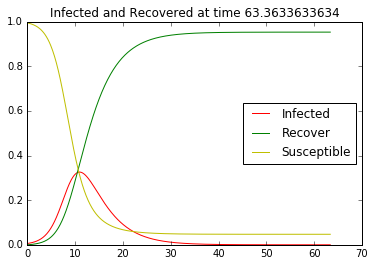

In [15]:
t_max = 100
t_n = 1000
(U, t_all) = sim (0.2, 11, 11, 0.8, 1.0/4, 0.5, 0.1, 0.1, t_max, t_n, verbose=False, impulse=[(0.5,0.5)])
            #sim (c,   m,  n, tau, rho, i0,   dx, dy,  t_max, n_t, verbose=False, impulse=None)
i_means = []
s_means = []
r_means = []
for t in range(len(t_all)):
    i_mean = np.sum(U[t,:,:,0])/11**2
    s_mean = np.sum(U[t,:,:,1])/11**2
    r_mean = np.sum(U[t,:,:,2])/11**2
    i_means.append(i_mean)
    s_means.append(s_mean)
    r_means.append(r_mean)
    assert abs(( s_mean + i_mean + r_mean ) - 1.0) < 0.0001
    if (i_mean < 1e-5) or (s_mean < 1e-5):
        plt.figure(1)
        plt.title('Infected and Recovered at time ' + str(t_all[t]))
        plt.plot (t_all[0:t+1], i_means, 'r', label = 'Infected')
        plt.plot (t_all[0:t+1], r_means,'g', label = 'Recover')
        plt.plot (t_all[0:t+1], s_means, 'y', label = 'Susceptible')
        plt.legend(loc='center right')
        break

## Challenge b

In [89]:
# Function to compute a centered impulse as an initial condition
def gen_initial_b (m,n,y0,dx,dy, impulse=None):
    u = np.zeros ((m + 2,n + 2, 4), dtype=float)
    i_mid = int (n/2)
    j_mid = int (m/2)
    for x in range(1, n + 1):
        for y in range(1, m + 1):
            u[y][x][:] = np.array([0,1,0,0])
    
    if impulse is None:
        u[j_mid][i_mid][:] = y0
        u[j_mid+3][i_mid-3][:] = y0
    else:
        for point in impulse:
            (x,y) = (int(point[0]/dx)+1,int(point[1]/dx)+1)
            u[x,y] = y0
    return u

In [12]:
def f_sirode_b (G, t, m=M, n=N, tau=TAU, rho=RHO, c=C, v=V, dx=dx, dy=dy):
    assert type (G) is np.ndarray
    assert type (t) is float
    G = np.reshape(G, (m+2, n+2,4))
    newG = np.zeros((m+2, n+2, 4), dtype=float)
    # @YOUSE: Compute `f[:]`
    for x in range(1, G.shape[1]-1):
        for y in range(1, G.shape[0]-1): 
            f = np.zeros (np.array(G[y][x]).shape)
            x_diff = x_axis_diffusion(G, x, y, c, dx)
            y_diff = y_axis_diffusion(G, x, y, c, dy)
            cell = G[y][x]
            f[0] = tau*cell[0]*cell[1] - rho*cell[0] + (x_diff + y_diff)*cell[1]
            f[1] = -tau*cell[0]*cell[1] - (x_diff + y_diff)*cell[1] - v*cell[1]*cell[0]/(cell[0]+cell[1])
            f[2] = rho*cell[0]
            f[3] = v*cell[1]*cell[0]/(cell[0]+cell[1])
            newG[y][x] = f
    return np.reshape(newG, (m+2)*(n+2)*4)

In [13]:
def sim_b (c, v, m, n, tau, rho, i0, dx, dy, t_max, n_t, verbose=False, impulse=None):
    y0 = np.array ([i0, 1.0-i0, 0.0, 0.0])
    G = gen_initial_b (m, n, y0, dx, dy, impulse)
    t_all = np.linspace (0.0, t_max, n_t)
    U = odeint (f_sirode_b, np.reshape(G, (m+2)*(n+2)*4), t_all, args=(m,n, tau, rho,c,dx,dy))
    U = np.reshape(U, (n_t, m+2, n+2, 4))
    if verbose:
        print ("Time points:", t_all)
        
    return (U, t_all)

In [94]:
def show_results_b(U, n_t):
    minInit = np.amin(U[0,:,:,:])
    maxInit = np.amax(U[0,:,:,:])
    plt.figure(1)
    plt.title('Initial Infected')
    plot(U[0,:,:,0], minInit, maxInit)
    #print('\n\n===================Initial Infected===================')
    #print(U[0,:,:,0])
    
    plt.figure(2)
    plt.title('Initial Susceptible')
    plot(U[0,:,:,1], minInit, maxInit)
    #print('\n\n===================Initial Susceptible===================')
    #print(U[0,:,:,1])
    
    plt.figure(3) 
    plt.title('Initial Recovered')
    plot(U[0,:,:,2], minInit, maxInit)
    #print('\n\n===================Initial Recovered===================')
    #print(U[0,:,:,2])
    
    plt.figure(4) 
    plt.title('Initial Vaccinate')
    plot(U[0,:,:,3], minInit, maxInit)
    #print('\n\n===================Initial Recovered===================')
    #print(U[0,:,:,3])

    minFinal = np.amin(U[n_t-1,:,:,:])
    maxFinal = np.amax(U[n_t-1,:,:,:])
    
    plt.figure(5) 
    plt.title('Final Infected')
    plot(U[n_t - 1,:,:,0], minFinal, maxFinal)
    #print('\n\n===================Final Infected===================')
    #print(U[n_t - 1,:,:,0])
    
    plt.figure(6) 
    plt.title('Final Susceptible')
    plot(U[n_t - 1,:,:,1], minFinal, maxFinal)
    #print('\n\n===================Final Susceptible===================')
    #print(U[n_t - 1,:,:,1])
    
    plt.figure(7)
    plt.title('Final Recovered')
    plot(U[n_t - 1,:,:,2],minFinal, maxFinal)
    #print('\n\n===================Final Recovered===================')
    #print(U[n_t - 1,:,:,2])
    
    plt.figure(8) 
    plt.title('Final Vaccinate')
    plot(U[n_t - 1,:,:,3], minInit, maxInit)
    #print('\n\n===================Initial Recovered===================')
    #print(U[n_t - 1,:,:,3])

<function __main__.isim_b>

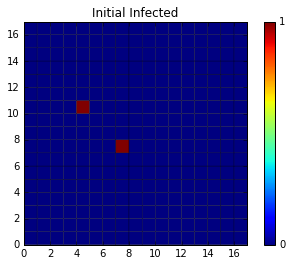

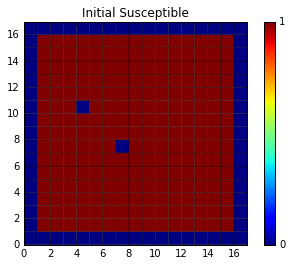

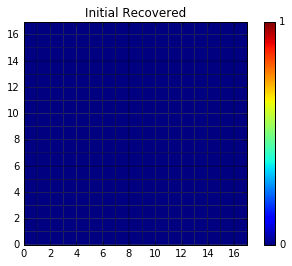

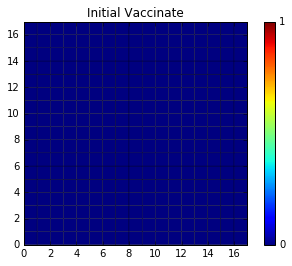

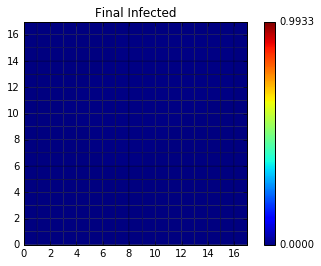

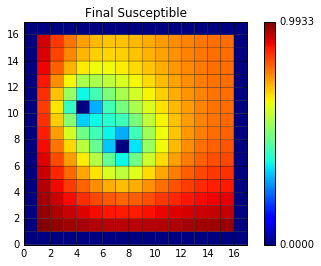

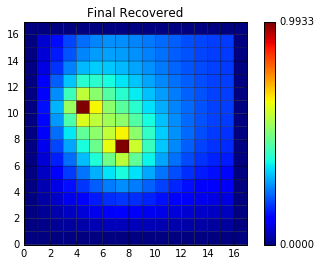

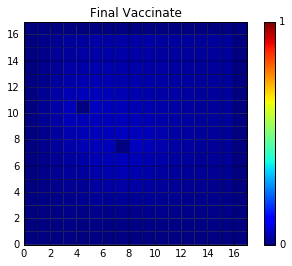

In [95]:
def isim_b (tau=TAU, rho=RHO, i0=1, t_max=10.0, n_t=10, c=C, v=V, m=M, n=N, lx=L_x, ly=L_y):
    assert t_max > 0.0
    dx = float (lx) / (n-1)       # Grid resolution
    dy = float (ly) / (m-1)
    (U, t_all) = sim_b(c, v, m, n, tau, rho, i0, dx, dy, t_max, n_t)
    show_results_b(U, n_t)
    
interact (isim_b
     , tau=(0.0, 2, 0.1)
     , rho=(0.0, 2.0, 0.1)
     , i0=(0.0, 1.0, 0.01)
     , t_max=(0.0, 20, 1.0)
     , n_t=(1, 500, 10)
     , c=(0, 0.5, 0.1)
     , v=(0, 1, 0.1)
     , m=(5, 30, 1)
     , n=(5, 30, 1)
     , lx=(0.5, 2, 0.1)
     , ly=(0.5, 2, 0.1)
    )